In [19]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from scipy import ndimage
from skimage.measure import regionprops
from skimage import io
from skimage.filters import threshold_otsu   # For finding the threshold for grayscale to binary conversion
import tensorflow as tf
import pandas as pd
import numpy as np
from time import time
import keras

In [20]:
genuine_image_paths = "D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\real/"
forged_image_paths = "D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\forged/"



In [21]:
def rgbgrey(img):
    # Converts rgb to grayscale
    greyimg = np.zeros((img.shape[0], img.shape[1]))
    for row in range(len(img)):
        for col in range(len(img[row])):
            greyimg[row][col] = np.average(img[row][col])
    return greyimg

In [22]:
def greybin(img):
    # Converts grayscale to binary
    blur_radius = 0.8
    img = ndimage.gaussian_filter(img, blur_radius)  # to remove small components or noise
#     img = ndimage.binary_erosion(img).astype(img.dtype)
    thres = threshold_otsu(img)
    binimg = img > thres
    binimg = np.logical_not(binimg)
    return binimg

In [23]:
def preproc(path, img=None, display=True):
    if img is None:
        img = mpimg.imread(path)
    # if display:
    #     print("RGB Image")
    #     plt.imshow(img)
    #     plt.show()
    grey = rgbgrey(img) #rgb to grey
    # if display:
    #     print("Greyscale Image")
    #     plt.imshow(grey, cmap = matplotlib.cm.Greys_r)
    #     plt.show()
    binimg = greybin(grey) #grey to binary
    if display:
        print("Binary Image")
        plt.imshow(binimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    r, c = np.where(binimg==1)
    # Now we will make a bounding box with the boundary as the position of pixels on extreme.
    # Thus we will get a cropped image with only the signature part.
    signimg = binimg[r.min(): r.max(), c.min(): c.max()]
    if display:
        print("Cropped Image")
        plt.imshow(signimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    return signimg

In [24]:
def Ratio(img):
    a = 0
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                a = a+1
    total = img.shape[0] * img.shape[1]
    return a/total

In [25]:
def Centroid(img):
    numOfWhites = 0
    a = np.array([0,0])
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                b = np.array([row,col])
                a = np.add(a,b)
                numOfWhites += 1
    rowcols = np.array([img.shape[0], img.shape[1]])
    centroid = a/numOfWhites
    centroid = centroid/rowcols
    return centroid[0], centroid[1]

In [26]:
def SkewKurtosis(img):
    h,w = img.shape
    x = range(w)  # cols value
    y = range(h)  # rows value
    #calculate projections along the x and y axes
    xp = np.sum(img,axis=0)
    yp = np.sum(img,axis=1)
    #centroid
    cx = np.sum(x*xp)/np.sum(xp)
    cy = np.sum(y*yp)/np.sum(yp)
    #standard deviation
    x2 = (x-cx)**2
    y2 = (y-cy)**2
    sx = np.sqrt(np.sum(x2*xp)/np.sum(img))
    sy = np.sqrt(np.sum(y2*yp)/np.sum(img))
    
    #skewness
    x3 = (x-cx)**3
    y3 = (y-cy)**3
    skewx = np.sum(xp*x3)/(np.sum(img) * sx**3)
    skewy = np.sum(yp*y3)/(np.sum(img) * sy**3)

    #Kurtosis
    x4 = (x-cx)**4
    y4 = (y-cy)**4
    # 3 is subtracted to calculate relative to the normal distribution
    kurtx = np.sum(xp*x4)/(np.sum(img) * sx**4) - 3
    kurty = np.sum(yp*y4)/(np.sum(img) * sy**4) - 3

    return (skewx , skewy), (kurtx, kurty)

In [27]:
def EccentricitySolidity(img):
    r = regionprops(img.astype("int8"))
    return r[0].eccentricity, r[0].solidity

In [28]:
def getFeatures(path, img=None, display=False):
    if img is None:
        img = mpimg.imread(path)
    img = preproc(path, display=display)
    ratio = Ratio(img)
    centroid = Centroid(img)
    eccentricity, solidity = EccentricitySolidity(img)
    skewness, kurtosis = SkewKurtosis(img)
    retVal = (ratio, centroid, eccentricity, solidity, skewness, kurtosis)
    return retVal

In [29]:
def getCSVFeatures(path, img=None, display=False):
    if img is None:
        img = mpimg.imread(path)
    temp = getFeatures(path, display=display)
    features = (temp[0], temp[1][0], temp[1][1], temp[2], temp[3], temp[4][0], temp[4][1], temp[5][0], temp[5][1])
    return features

## Saving the features

In [30]:
def makeCSV():
    if not(os.path.exists('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\Features')):
        os.mkdir('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\Features')
        print('New folder "Features" created')
        
    if not(os.path.exists('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\Features/Training')):
        os.mkdir('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\Features/Training')
        print('New folder "Features/Training" created')

    if not(os.path.exists('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\Features/Testing')):
        os.mkdir('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\Features/Testing')
        print('New folder "Features/Testing" created')
    # genuine signatures path
    gpath = genuine_image_paths
    # forged signatures path
    fpath = forged_image_paths
    for person in range(1,15):
        per = ('00'+str(person))[-3:]
        print('Saving features for person id-',per)
        
        with open('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\Features\\Training/training_'+per+'.csv', 'w') as handle:
            handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
            # Training set
            for i in range(0,3):
                source = os.path.join(gpath, per+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',1\n')
            for i in range(0,3):
                source = os.path.join(fpath, '021'+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',0\n')
        
        with open('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\Features\\Testing/testing_'+per+'.csv', 'w') as handle:
            handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
            # Testing set
            for i in range(3, 5):
                source = os.path.join(gpath, per+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',1\n')
            for i in range(3,5):
                source = os.path.join(fpath, '021'+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',0\n')

In [32]:
makeCSV()

Saving features for person id- 001
Saving features for person id- 002
Saving features for person id- 003
Saving features for person id- 004
Saving features for person id- 005
Saving features for person id- 006
Saving features for person id- 007
Saving features for person id- 008
Saving features for person id- 009
Saving features for person id- 010
Saving features for person id- 011
Saving features for person id- 012
Saving features for person id- 013
Saving features for person id- 014


# TF Model 

In [40]:
def testing(path):
    feature = getCSVFeatures(path)
    if not(os.path.exists('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\TestFeatures')):
        os.mkdir('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\TestFeatures')
    with open('D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\TestFeatures/testcsv.csv', 'w') as handle:
        handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y\n')
        handle.write(','.join(map(str, feature))+'\n')

In [41]:
n_input = 9
train_person_id = input("Enter person's id : ")
test_image_path = input("Enter path of signature image : ")
train_path = 'D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\Features\\Training/training_'+train_person_id+'.csv'
testing(test_image_path)
test_path = 'D:\\Arpit College\\FYP\\SignatureVerificationSystem\\Data\\TestFeatures/testcsv.csv'

def readCSV(train_path, test_path, type2=False):
    # Reading train data
    df = pd.read_csv(train_path, usecols=range(n_input))
    train_input = np.array(df.values)
    train_input = train_input.astype(np.float32, copy=False)  # Converting input to float_32
    df = pd.read_csv(train_path, usecols=(n_input,))
    temp = [elem[0] for elem in df.values]
    correct = np.array(temp)
    corr_train = keras.utils.to_categorical(correct,2)      # Converting to one hot
    # Reading test data
    df = pd.read_csv(test_path, usecols=range(n_input))
    test_input = np.array(df.values)
    test_input = test_input.astype(np.float32, copy=False)
    if not(type2):
        df = pd.read_csv(test_path, usecols=range(n_input))
        temp = [elem[0] for elem in df.values]
        correct = np.array(temp)
        corr_test = keras.utils.to_categorical(correct,2)      # Converting to one hot
    if not(type2):
        return train_input, corr_train, test_input, corr_test
    else:
        return train_input, corr_train, test_input

tf.reset_default_graph()
# Parameters
learning_rate = 0.001
training_epochs = 10000
display_step = 1


# Network Parameters
n_hidden_1 = 7 # 1st layer number of neurons
n_hidden_2 = 13 # 2nd layer number of neurons
# n_hidden_3 = 13 # 3rd layer
n_classes = 2 # no. of classes (genuine or forged)

# tf Graph input
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], seed=1)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],seed=2)),
    # 'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3], seed=1)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], seed=2))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1], seed=1)),
    'b2': tf.Variable(tf.random_normal([n_hidden_2], seed=2)),
    # 'b3': tf.Variable(tf.random_normal([n_hidden_3], seed=2)),
    'out': tf.Variable(tf.random_normal([n_classes], seed=1))
}


# Create model
def multilayer_perceptron(x):
    layer_1 = tf.tanh((tf.matmul(x, weights['h1']) + biases['b1']))
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    out_layer = tf.tanh(tf.matmul(layer_2, weights['out']) + biases['out'])
    return out_layer

# Construct model
logits = multilayer_perceptron(X)

# Define loss and optimizer

loss_op = tf.reduce_mean(tf.squared_difference(logits, Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# For accuracies
pred = tf.nn.softmax(logits)  # Apply softmax to logits
correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

def evaluate(train_path, test_path, type2=False):   
    if not(type2):
        train_input, corr_train, test_input, corr_test = readCSV(train_path, test_path)
    else:
        train_input, corr_train, test_input = readCSV(train_path, test_path, type2)
    ans = 'Random'
    costs=[]

    with tf.Session() as sess:
        sess.run(init)
        # Training cycle
        for epoch in range(training_epochs):

            # Run optimization op (backprop) and cost op (to get loss value)
            _, cost = sess.run([train_op, loss_op], feed_dict={X: train_input, Y: corr_train})
            costs.append(cost)

            # if epoch==training_epochs-1:
            #     print (epoch , cost)

            if epoch%100==0:
                print(epoch , cost)
            elif epoch==training_epochs-1:
                print(epoch , cost)

            if cost<0.0001:
                break
#             # Display logs per epoch step
        #     if epoch % 999 == 0:
        #         print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(cost))
        print("Optimization Finished!")

         # Plot the cost values
        plt.plot(costs)
        plt.xlabel('Epoch')
        plt.ylabel('Cost')
        plt.title('Cost vs. Epoch')
        plt.show()


        # Finding accuracies
        accuracy1 =  accuracy.eval({X: train_input, Y: corr_train})
        print("Accuracy for train:", accuracy1)
        
        if type2 is False:
            accuracy2 =  accuracy.eval({X: test_input, Y: corr_test})   

            return accuracy1, accuracy2
            
        else:
            prediction = pred.eval({X: test_input})
            if prediction[0][1]>prediction[0][0]:
                print('Genuine Image')
                return True
            else:
                print('Forged Image')
                return False


def trainAndTest(rate=0.001, epochs=10000, neurons=7, display=False):    
    start = time()

    # Parameters
    global training_rate, training_epochs, n_hidden_1
    learning_rate = rate
    training_epochs = epochs

    # Network Parameters
    n_hidden_1 = neurons # 1st layer number of neurons
    n_hidden_2 = 13 # 2nd layer number of neurons

    train_avg, test_avg = 0, 0
    n = 14
    for i in range(1,n+1):
        if display:
            print("Running for Person id",i)
        temp = ('0'+str(i))[-2:]
        train_score, test_score = evaluate(train_path.replace('01',temp), test_path.replace('01',temp))
        train_avg += train_score
        test_avg += test_score
    if display:
        print("Number of neurons in Hidden layer-", n_hidden_1)
        print("Number of neurons in Hidden layer-", n_hidden_2)
        print("Training average-", train_avg/n)
        print("Testing average-", test_avg/n)
        print("Time taken-", time()-start)
        print("Learning rate- ", learning_rate)
    return train_avg/n, test_avg/n, (time()-start)/n

# trainAndTest(display=True)




In [ ]:
evaluate(train_path, test_path, type2=True)

Running for Person id 1
0 0.49950442
100 0.2322536
200 0.02678431
300 0.010584029
400 0.008112325
500 0.006744432
600 0.005702892
700 0.004884756
800 0.0042366316
900 0.0037049807
1000 0.003237272
1100 0.002786192
1200 0.0023233816
1300 0.001857751
1400 0.0014214962
1500 0.0010380907
1600 0.00072348764
1700 0.00048760197
1800 0.00032707068
1900 0.0002256658
2000 0.00016258
2100 0.00012287473
Optimization Finished!


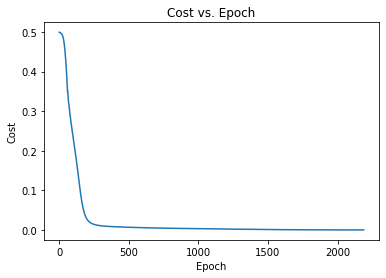

Accuracy for train: 1.0
Running for Person id 2
0 1.4916519
100 0.49060705
200 0.45513877
300 0.31247818
400 0.256056
500 0.21477239
600 0.13731167
700 0.059877127
800 0.036207706
900 0.025622362
1000 0.020339532
1100 0.017107612
1200 0.014697577
1300 0.012648046
1400 0.010777245
1500 0.009026808
1600 0.007402519
1700 0.0059427437
1800 0.00469729
1900 0.0036808082
2000 0.0028774685
2100 0.0022998976
2200 0.0017934538
2300 0.0014418621
2400 0.0012132389
2500 0.00097431656
2600 0.00082898774
2700 0.0006957178
2800 0.0005998611
2900 0.0005190574
3000 0.00045521607
3100 0.00040155207
3200 0.00035772318
3300 0.0003198937
3400 0.00028858802
3500 0.0002600969
3600 0.0002649937
3700 0.00021531335
3800 0.00020144123
3900 0.00018070155
4000 0.00016680598
4100 0.0001534649
4200 0.00014217598
4300 0.00013171534
4400 0.00012527198
4500 0.00011393327
4600 0.000110962545
Optimization Finished!


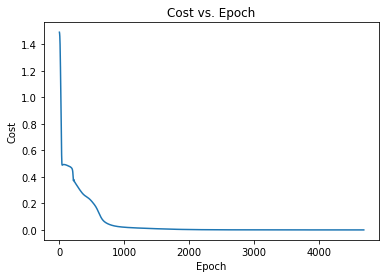

Accuracy for train: 1.0
Running for Person id 3
0 1.4875083
100 0.67253953
200 0.49769703
300 0.48428047
400 0.46465588
500 0.33971548
600 0.2508178
700 0.25058684
800 0.25044948
900 0.25035444
1000 0.25028613
1100 0.25023547
1200 0.25019684
1300 0.25016677
1400 0.25014287
1500 0.2501236
1600 0.2501078
1700 0.2500947
1800 0.25008374
1900 0.25007448
2000 0.25006655
2100 0.25005972
2200 0.2500538
2300 0.25004867
2400 0.25004417
2500 0.2500402
2600 0.2500367
2700 0.25003353
2800 0.25003076
2900 0.25002825
3000 0.25002602
3100 0.250024
3200 0.25002214
3300 0.2500205
3400 0.25001898
3500 0.2500176
3600 0.25001636
3700 0.2500152
3800 0.25001416
3900 0.2500132
4000 0.2500123
4100 0.25001147
4200 0.25001073
4300 0.25001
4400 0.2500094
4500 0.2500088
4600 0.25000823
4700 0.25000772
4800 0.25000724
4900 0.25000677
5000 0.25000635
5100 0.250006
5200 0.25000563
5300 0.25000528
5400 0.25000498
5500 0.25000468
5600 0.25000438
5700 0.25000414
5800 0.2500039
5900 0.25000417
6000 0.2500035
6100 0.25000

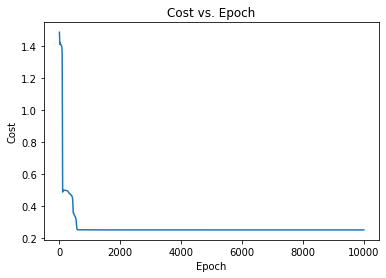

Accuracy for train: 0.5
Running for Person id 4
0 1.2148644
100 0.47103587
200 0.18955858
300 0.17233343
400 0.16735812
500 0.16446179
600 0.12962146
700 0.07776145
800 0.017786829
900 0.004834614
1000 0.0017092625
1100 0.0009382674
1200 0.00063167285
1300 0.0004653102
1400 0.00036051372
1500 0.00028879146
1600 0.00023700645
1700 0.00019816327
1800 0.00016816093
1900 0.0001444453
2000 0.00012533758
2100 0.000109691995
Optimization Finished!


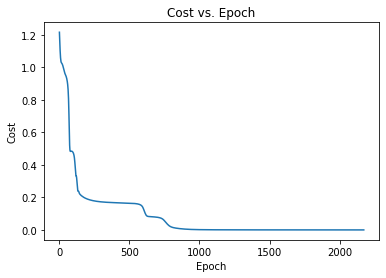

Accuracy for train: 1.0
Running for Person id 5
0 1.4097213
100 0.4180385
200 0.40976298
300 0.32707533
400 0.16953933
500 0.1672585
600 0.16659428
700 0.16584548
800 0.16424526
900 0.12922508
1000 0.005537232
1100 0.00062286673
1200 0.00022964615
1300 0.00013636482
Optimization Finished!


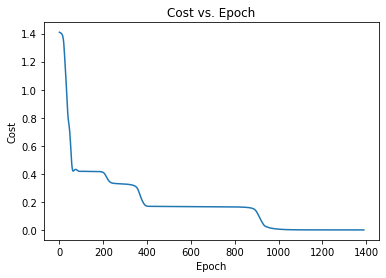

Accuracy for train: 1.0
Running for Person id 6
0 0.47148323
100 0.32189968
200 0.26781887
300 0.07662535
400 0.05598791
500 0.02390278
600 0.00921864
700 0.004788849
800 0.0026128518
900 0.0015272595
1000 0.00097277324
1100 0.00066914177
1200 0.0004888756
1300 0.0003737997
1400 0.00029682103
1500 0.00024257977
1600 0.00024438687
1700 0.00017259881
1800 0.00014979
1900 0.00013053493
2000 0.0001156992
2100 0.0001028179
Optimization Finished!


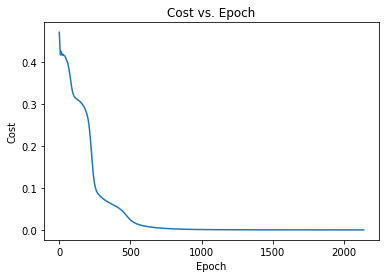

Accuracy for train: 1.0
Running for Person id 7
0 0.4968125
100 0.17832892
200 0.16167475
300 0.14672583
400 0.1384957
500 0.13101333
600 0.11423396
700 0.08824142
800 0.061629925
900 0.03671741
1000 0.018909192
1100 0.010264826
1200 0.0060846563
1300 0.0039440426
1400 0.002742978
1500 0.002027777
1600 0.0015718341
1700 0.0012488316
1800 0.0010247839
1900 0.0008588848
2000 0.00074451807
2100 0.0006302562
2200 0.00055056735
2300 0.00048483373
2400 0.00043082735
2500 0.0003853468
2600 0.00034708707
2700 0.00034025512
2800 0.00028588413
2900 0.0002794217
3000 0.00023936969
3100 0.0002273845
3200 0.00020318119
3300 0.00019184977
3400 0.00017448759
3500 0.00016264002
3600 0.00015124056
3700 0.00015028009
3800 0.00013207164
3900 0.00012427922
4000 0.00011629512
4100 0.00010996143
4200 0.00010287605
Optimization Finished!


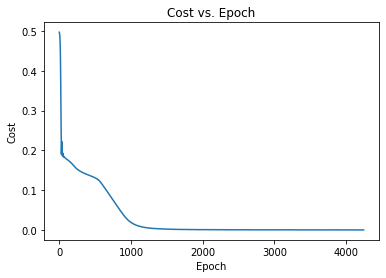

Accuracy for train: 1.0
Running for Person id 8
0 0.4986595
100 0.28337717
200 0.19057971
300 0.1567992
400 0.14216287
500 0.102198154
600 0.05699333
700 0.030910244
800 0.016636578
900 0.009843251
1000 0.006643858
1100 0.004946941
1200 0.003926517
1300 0.0032308295
1400 0.002707234
1500 0.0022900582
1600 0.0019364449
1700 0.0016749259
1800 0.0013618263
1900 0.0011402894
2000 0.00091694255
2100 0.00076867145
2200 0.0006041449
2300 0.0005127454
2400 0.00040798905
2500 0.00034266105
2600 0.00032486735
2700 0.0002517292
2800 0.00022002113
2900 0.00019503808
3000 0.00018400636
3100 0.0001590349
3200 0.00014056574
3300 0.0001290444
3400 0.00014139785
3500 0.000107412336
Optimization Finished!


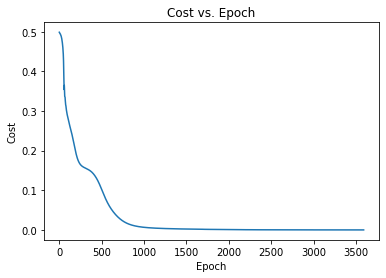

Accuracy for train: 1.0
Running for Person id 9
0 0.76379377
100 0.41272464
200 0.21273129
300 0.1460345
400 0.11148315
500 0.073913775
600 0.049197033
700 0.03506252
800 0.024510846
900 0.016494734
1000 0.010867324
1100 0.007198145
1200 0.004899327
1300 0.0034627991
1400 0.0025439432
1500 0.001935064
1600 0.0015161168
1700 0.0012182944
1800 0.0010061929
1900 0.0008458399
2000 0.0007228241
2100 0.0006273983
2200 0.0005500513
2300 0.0004870732
2400 0.00043447837
2500 0.00039120144
2600 0.0003528264
2700 0.00032084345
2800 0.00029287537
2900 0.00026899565
3000 0.0002472783
3100 0.00022913101
3200 0.00021152501
3300 0.00019738066
3400 0.00018298562
3500 0.00017697764
3600 0.00015969225
3700 0.00015456967
3800 0.00014053774
3900 0.00015746983
4000 0.00012454922
4100 0.00019140785
4200 0.00011101397
4300 0.00026307325
Optimization Finished!


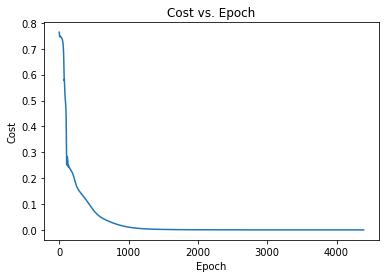

Accuracy for train: 1.0
Running for Person id 10
0 1.1004864
100 0.314432
200 0.120261036
300 0.073424526
400 0.03539073
500 0.023350127
600 0.016750038
700 0.012590063
800 0.00983243
900 0.007977611
1000 0.0067110793
1100 0.0057974868
1200 0.0050838673
1300 0.0044844057
1400 0.0039549177
1500 0.0034736767
1600 0.0030310228
1700 0.0026233925
1800 0.0022503517
1900 0.0019127581
2000 0.0016114265
2100 0.0013465919
2200 0.0011176234
2300 0.0009227195
2400 0.000759311
2500 0.00062410027
2600 0.0005134549
2700 0.00042364644
2800 0.00035116382
2900 0.00029279917
3000 0.0002458277
3100 0.00020791474
3200 0.00017717863
3300 0.00015212316
3400 0.00013155404
3500 0.00011544739
3600 0.00010050082
Optimization Finished!


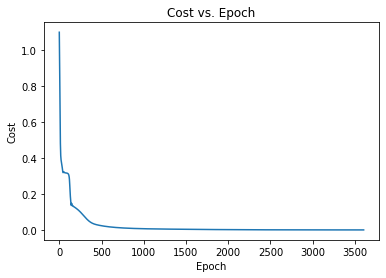

Accuracy for train: 1.0
Running for Person id 11
0 1.2577846
100 0.46248913
200 0.43301845
300 0.26717213
400 0.25611785
500 0.2542096
600 0.2528712
700 0.2519796
800 0.25140557
900 0.25103474
1000 0.25078866
1100 0.25061938
1200 0.25049874
1300 0.25041
1400 0.25034282
1500 0.25029078
1600 0.25024965
1700 0.25021657
1800 0.25018945
1900 0.250167
2000 0.2501482
2100 0.2501323
2200 0.2501187
2300 0.25010702
2400 0.25009683
2500 0.25008795
2600 0.25008014
2700 0.25007322
2800 0.25006709
2900 0.25006166
3000 0.25005677
3100 0.25005233
3200 0.25004837
3300 0.2500447
3400 0.25004146
3500 0.25003847
3600 0.25003573
3700 0.25003323
3800 0.25003096
3900 0.25002885
4000 0.2500269
4100 0.25002515
4200 0.25002348
4300 0.25002196
4400 0.2500205
4500 0.25001922
4600 0.25001797
4700 0.25001678
4800 0.25001577
4900 0.25001475
5000 0.25001386
5100 0.2500129
5200 0.25001207
5300 0.25001135
5400 0.2500106
5500 0.25000992
5600 0.25000927
5700 0.2500086
5800 0.25000814
5900 0.25000837
6000 0.25000712
6100 

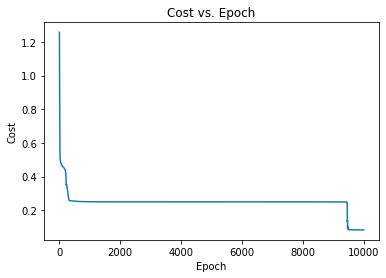

Accuracy for train: 0.8333333
Running for Person id 12
0 1.4925343
100 0.49679825
200 0.48009148
300 0.4366977
400 0.3050352
500 0.24014775
600 0.21374531
700 0.18323588
800 0.17201893
900 0.16803254
1000 0.16444112
1100 0.015931351
1200 0.0015760978
1300 0.0007728048
1400 0.0004958474
1500 0.0003575474
1600 0.0002749884
1700 0.00022033737
1800 0.00018163149
1900 0.00015288244
2000 0.00013075648
2100 0.00011325389
Optimization Finished!


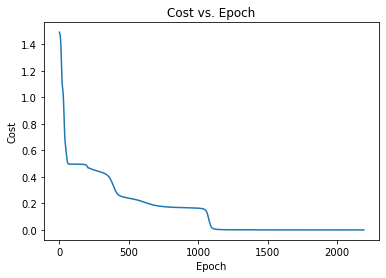

Accuracy for train: 1.0
Running for Person id 13
0 1.4176031
100 0.5002175
200 0.50015515
300 0.4984068
400 0.26776686
500 0.26485398
600 0.26200333
700 0.25993183
800 0.2583982
900 0.25704458
1000 0.25581887
1100 0.2547417
1200 0.25382015
1300 0.25304782
1400 0.2524118
1500 0.2518972
1600 0.2514877
1700 0.25116682
1800 0.25091827
1900 0.25072727
2000 0.25058106
2100 0.25046888
2200 0.25038376
2300 0.25031927
2400 0.25026724
2500 0.2502271
2600 0.250196
2700 0.2501687
2800 0.2501491
2900 0.25012934
3000 0.25011435
3100 0.25012842
3200 0.25009096
3300 0.25008276
3400 0.25007346
3500 0.25006795
3600 0.2500602
3700 0.25005493
3800 0.2500502
3900 0.25004563
4000 0.25005022
4100 0.25003842
4200 0.25003895
4300 0.25003254
4400 0.25003004
4500 0.25004724
4600 0.2500258
4700 0.25002396
4800 0.25002232
4900 0.25002083
5000 0.25002477
5100 0.25001815
5200 0.2500176
5300 0.250016
5400 0.25001523
5500 0.25001422
5600 0.25001344
5700 0.2500126
5800 0.250012
5900 0.2500113
6000 0.25001076
6100 0.250

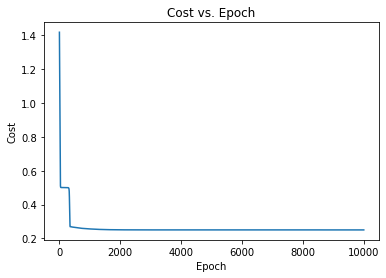

Accuracy for train: 0.6666667
Running for Person id 14
0 0.48943278
100 0.35135594
200 0.22224398
300 0.1456888
400 0.097799085
500 0.07694656
600 0.05611695
700 0.03724237
800 0.02614828
900 0.018643564
1000 0.013091409
1100 0.008983227
1200 0.0060789115
1300 0.0041442392
1400 0.002899824
1500 0.0021316605
1600 0.0015942912
1700 0.0012493551
1800 0.0010086377
1900 0.00083854346
2000 0.00070470717
2100 0.0006033119
2200 0.00052428385
2300 0.00056926184
2400 0.00040790733
2500 0.00036460286
2600 0.00032791635
2700 0.00029746618
2800 0.00027039848
2900 0.00024801152
3000 0.00022786914
3100 0.0002109569
3200 0.00019495752
3300 0.00018236303
3400 0.00016901433
3500 0.00015914936
3600 0.00014804084
3700 0.00014086139
3800 0.00013111766
3900 0.00012588895
4000 0.00011706472
4100 0.000110823465
4200 0.00010836102
Optimization Finished!


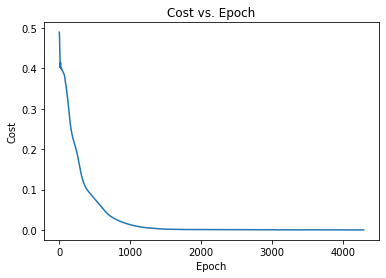

Accuracy for train: 1.0
Number of neurons in Hidden layer- 7
Number of neurons in Hidden layer- 13
Training average- 0.9285714285714286
Testing average- 0.5
Time taken- 34.40571737289429
Learning rate-  0.001


(0.9285714285714286, 0.5, 2.4575512409210205)

In [42]:
trainAndTest(display=True)